In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn import linear_model
import warnings

plt.style.use("seaborn")

warnings.filterwarnings('ignore')

In [2]:
def plot_image(image, i = 0):
    l = [cv.COLOR_BGR2RGB, cv.COLOR_BGR2GRAY, cv.COLOR_RGB2GRAY,]
    plt.imshow(cv.cvtColor(image, l[i]))
    plt.show(block = True)

In [3]:
def display_image(image):
    cv.imshow('image', image)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [4]:
def plot_graph(image, i = 0):
    plt.figure(figsize = (15, 8))
    sns.scatterplot(np.arange(len(image.sum(i))), image.sum(i), label = 'a', alpha = 0.6)

#

In [5]:
def MinMaxScalar(x, a = -1, b = 1):
    N = (x - x.min()) * (b - a)
    D = (x.max() - x.min())
    return (N / D) + a

In [6]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

In [7]:
def softplus(t):
    return np.log(1 + np.exp(t))

#

In [8]:
def preprocess_image(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    blur = cv.bilateralFilter(gray, 3, 75, 75)
    
    thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    k = 3
    kernal = np.ones((k, k), np.uint8)
    dilate = cv.dilate(thresh, kernal, iterations = 1)
    
    k = 1
    kernal = np.ones((k, k), np.uint8)
    erode = cv.erode(dilate, kernal, iterations = 1)
    
    return erode

In [9]:
def line_extraction(preprocess_imaged, r_image):
    gray = cv.cvtColor(r_image, cv.COLOR_BGR2GRAY)
    
    # edges of image
    edges = cv.Canny(preprocess_imaged, 0, 125, apertureSize = 3)
    
    # probability of lines
    lines = cv.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength = int(r_image.shape[1] * 0.0002))
    
    # y val of all lines
    Y = [0,]
    for line in lines:
        x1, y1, x2, y2 = line[0]
#         cv.line(r_image, (x1, y1), (x2, y2), (0,255,0), 1)
        Y.append(y1)
    Y.append(gray.shape[0])
    Y = sorted(Y)

    # slope for y
    Y_m = []
    for i in range(len(Y)):
        if i == len(Y)-1:
            break
        Y_m.append(Y[i + 1] - Y[i])
    
    # seprerate the outlier and data
    LR = linear_model.LinearRegression()
    LR.fit(np.array(range(len(Y_m))).reshape(-1, 1), np.array(Y_m))
    m = LR.coef_ 
    c = LR.intercept_
    
    # assigning to outliers to  Y
    Y_bool = (np.array(Y_m) - (m * np.array(range(len(Y_m)))) - c) > 0
    Y_bool = np.where(Y_bool>0)[0]

    line_extractions = []
    for i in range(len(Y_bool)):
        line_extractions.append(r_image[:][Y[Y_bool[i]] : Y[Y_bool[i] + 1]])
    
    return line_extractions

In [10]:
def preprocess_line(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    blur = cv.bilateralFilter(gray, 3, 75, 75)
    
    thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    k = 5
    kernal = np.ones((k, k), np.uint8)
    dilate = cv.dilate(thresh, kernal, iterations = 1)
    
    k = 21
    kernal = np.ones((k, k), np.uint8)
    erode = cv.erode(dilate, kernal, iterations = 1)
    
    return erode

In [11]:
def word_extraction(preprocessed_line1, line1):
    sum_line = preprocessed_line1.sum(axis = 0)
    sum_line_scaled = MinMaxScalar(sum_line, -1, 1)
    scaled_activated_sum = softplus(sigmoid(sum_line_scaled))

    #model1
    l = scaled_activated_sum
    maximum = max(l)
    cutout_dip = []
    cutout_up = []
    
    for i in range(len(l)):
        if (i + 1) != len(l):
            if l[i] == maximum:
                if (l[i + 1] < maximum):
                    cutout_dip.append(i)
            
            if l[i] < maximum:
                if (l[i + 1] == maximum):
                    cutout_up.append(i)               
    
    #model2
    cutout_images = []
    gray_line1 = cv.cvtColor(line1, cv.COLOR_BGR2GRAY)
    for up, dip in zip(cutout_up, cutout_dip):
        temp = gray_line1[:, dip : up]
        cutout_images.append(temp)
    
    return cutout_images

In [12]:
def preprocess_word(image):
#     gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    blur = cv.bilateralFilter(image, 3, 75, 75)
    
    thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    k = 5
    kernal = np.ones((k, k), np.uint8)
    dilate = cv.dilate(thresh, kernal, iterations = 1)
    
    k = 15
    kernal = np.ones((k, k), np.uint8)
    erode = cv.erode(dilate, kernal, iterations = 1)
    
    return erode

In [13]:
def word_extraction_T(preprocessed_line1, line1):
    sum_line = preprocessed_line1.sum(axis = 0)
    sum_line_scaled = MinMaxScalar(sum_line, -1, 1)
    scaled_activated_sum = softplus(sigmoid(sum_line_scaled))

    #model1
    l = scaled_activated_sum
    maximum = max(l)
    cutout_dip = []
    cutout_up = []
    
    for i in range(len(l)):
        if (i + 1) != len(l):
            if l[i] == maximum:
                if (l[i + 1] < maximum):
                    cutout_dip.append(i)
            
            if l[i] < maximum:
                if (l[i + 1] == maximum):
                    cutout_up.append(i)               
    
    #model2
    cutout_images = []
#     gray_line1 = cv.cvtColor(line1, cv.COLOR_BGR2GRAY)
    for up, dip in zip(cutout_up, cutout_dip):
        temp = line1[:, dip : up]
        cutout_images.append(temp.T)
    
    return cutout_images

In [14]:
real_page = cv.imread('page03.jpg')

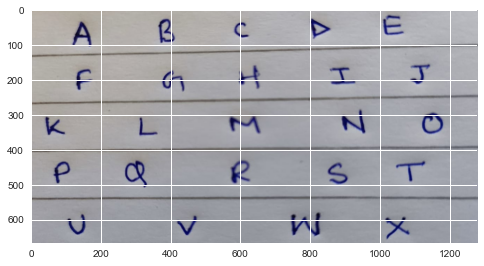

In [15]:
plot_image(real_page)

words


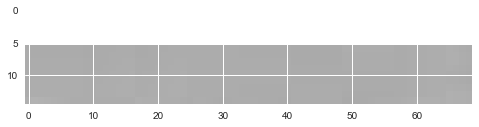

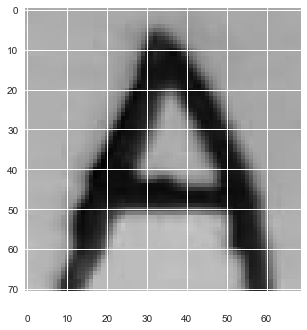

words


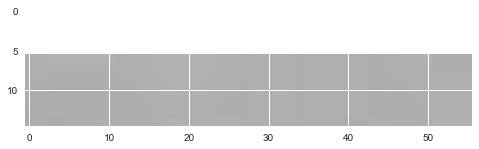

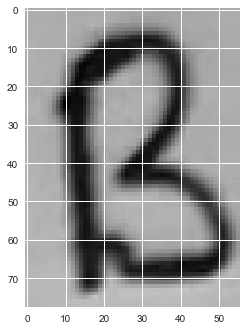

words


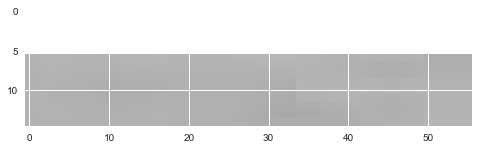

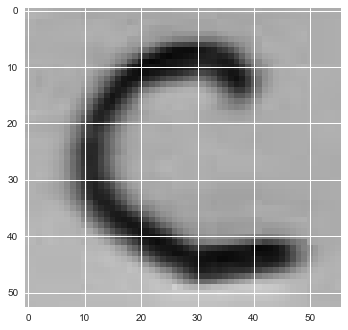

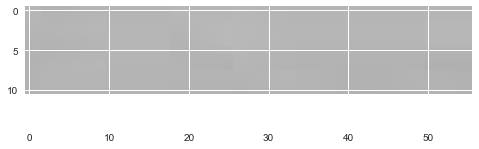

words


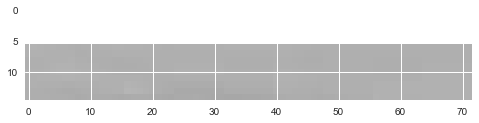

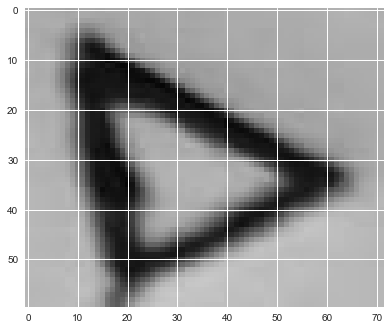

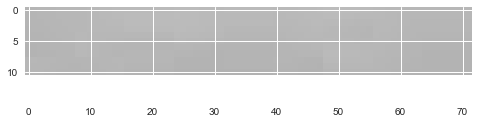

words


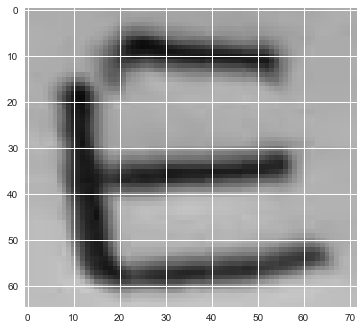

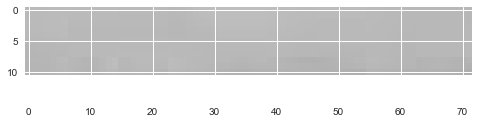

words


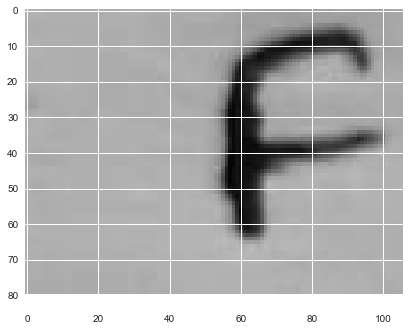

words


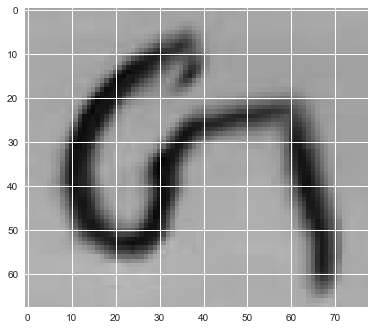

words


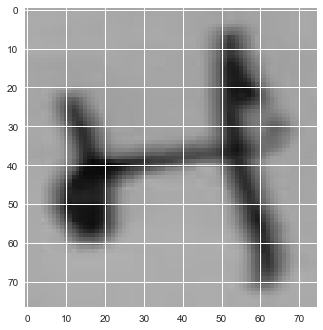

words


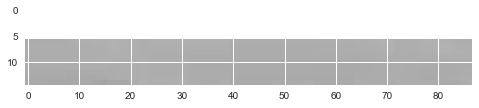

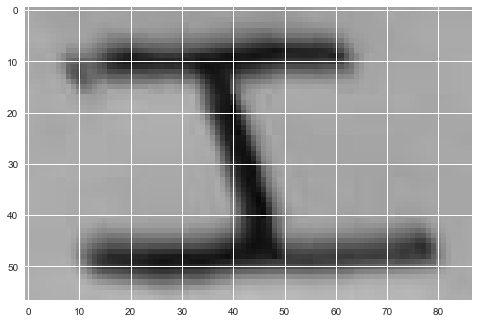

words


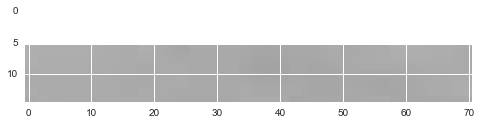

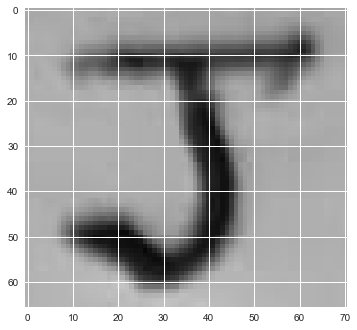

words


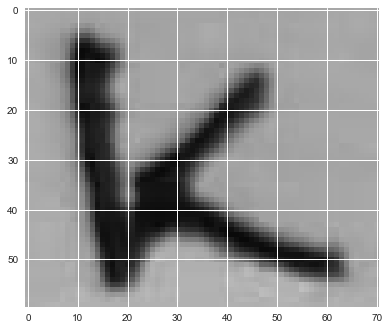

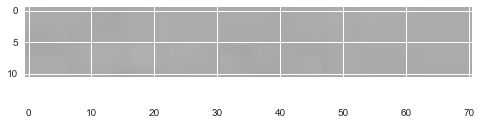

words


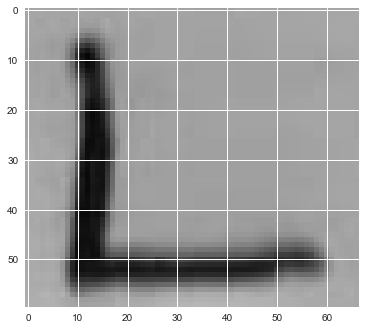

words


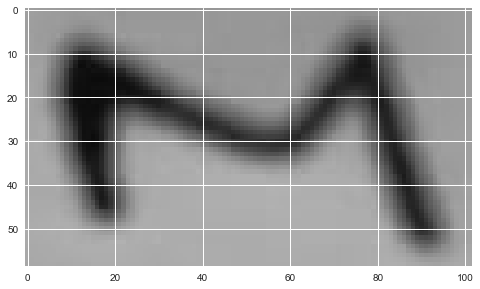

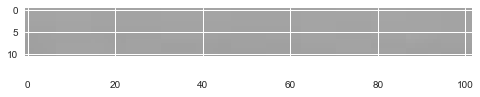

words


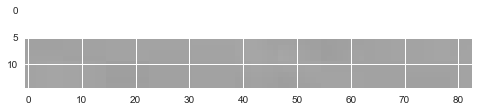

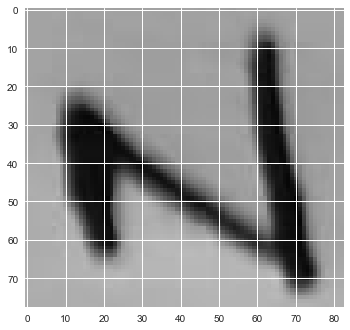

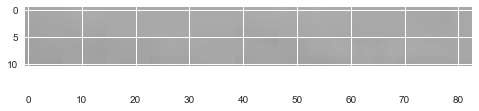

words


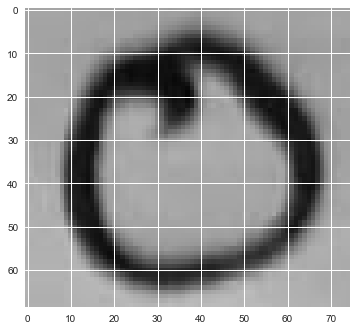

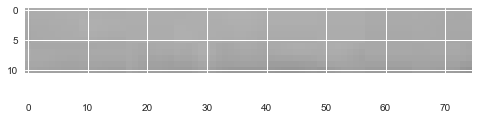

words


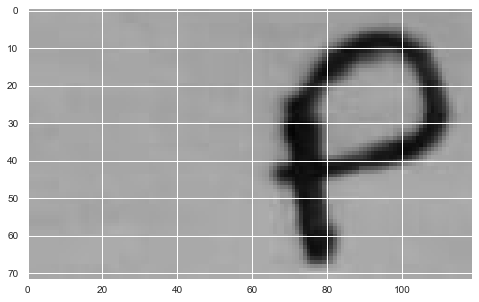

words


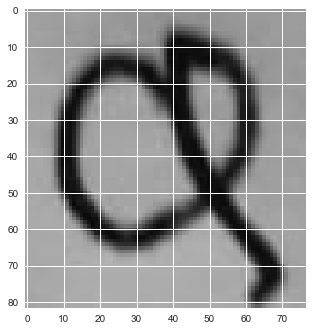

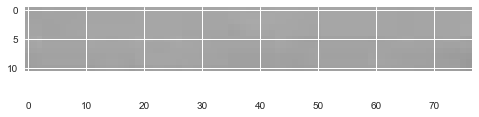

words


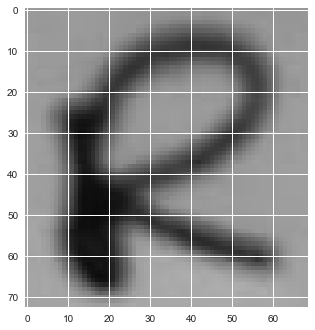

words


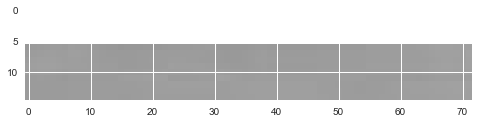

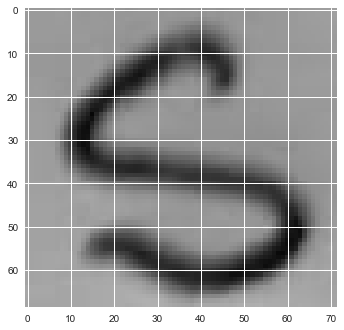

words


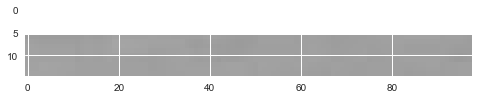

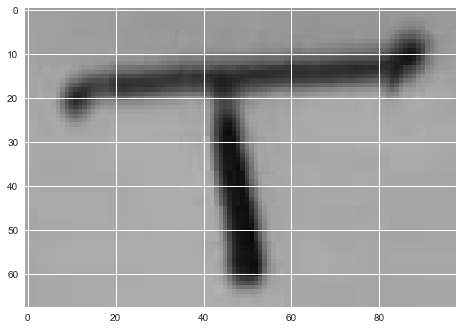

words


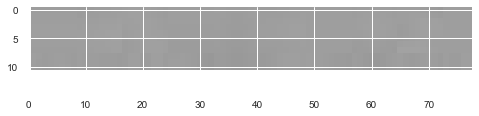

words


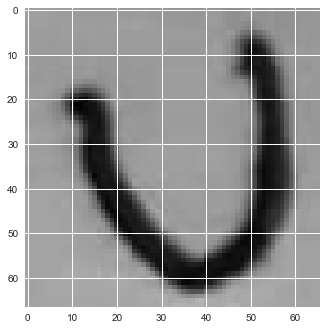

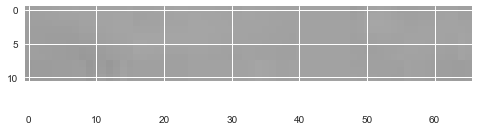

words


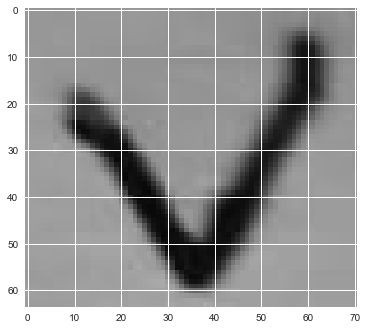

words


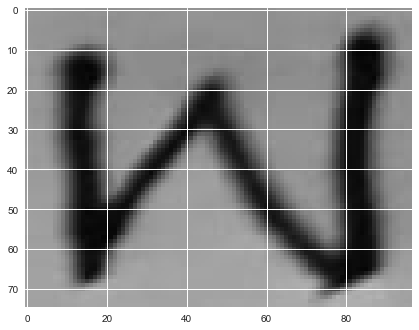

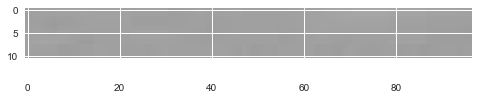

words


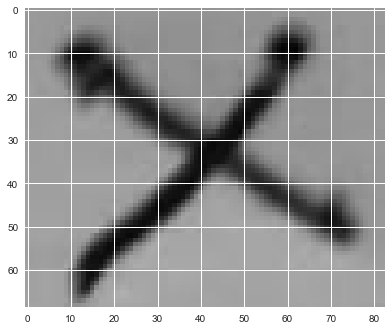

words


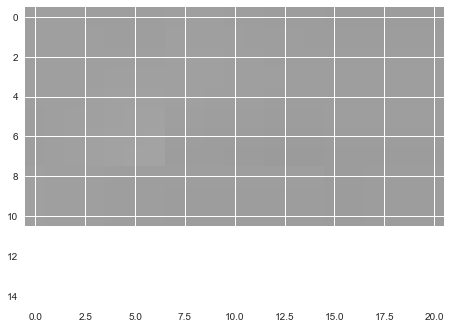

In [16]:
preprocess_page = preprocess_image(real_page)
line_extracted = line_extraction(preprocess_page, real_page)
for line in line_extracted:
#     plot_image(line)
    line_p = cv.copyMakeBorder(line, 0, 0, 20, 20, cv.BORDER_CONSTANT, value = (255, 255, 255))
    
    preprocessed_line = preprocess_line(line)
    preprocessed_line_p = cv.copyMakeBorder(preprocessed_line, 0, 0, 20, 20, cv.BORDER_CONSTANT, value = 255)
    
    word_extracted = word_extraction(preprocessed_line_p, line_p)
    for word in word_extracted:
#         plot_image(word)
        print('words')
        word_p = cv.copyMakeBorder(word, 10, 10, 0, 0, cv.BORDER_CONSTANT, value = 255)
        preprocessed_word = preprocess_word(word_p)
        word_t = preprocessed_word.T
        word_r = word_extraction_T(word_t, word_p.T)
        for word_ in word_r:
            plot_image(word_)

# expe

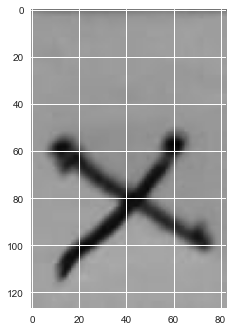

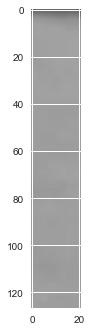

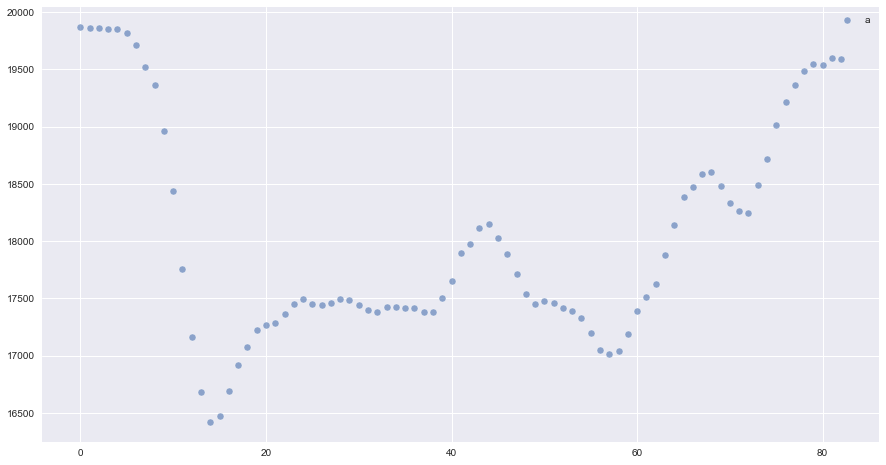

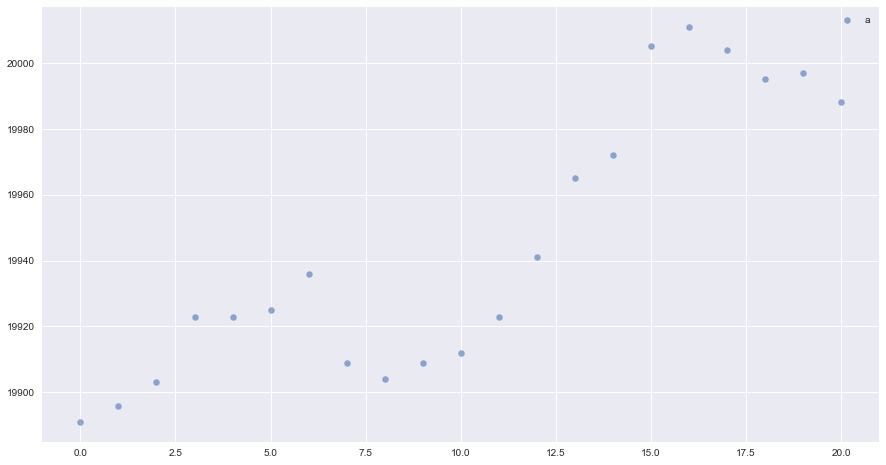

In [27]:
wanted, unwanted = word_extracted[-2], word_extracted[-1]
plot_image(wanted)
plot_image(unwanted)
plot_graph(wanted)
plot_graph(unwanted)

In [39]:
wanted.sum(axis=1).mean()

11774.354330708662

In [38]:
unwanted.sum(axis=1).mean()

3297.8897637795276

In [62]:
jkl = wanted.sum(axis=1)
arr = []
for llp in range(0,len(jkl)-1,2):
    print(jkl[llp+1]-jkl[llp])
#     arr.append(jkl[llp]-jkl[llp+1])

1165
519
62
91
23
4294967281
5
6
4294967273
4294967281
4294967287
4294967279
4294967279
4294967287
4294967295
4294967282
4294967281
4294967290
4294967285
11
7
4294967289
4294967280
4294967228
4294967183
4294967158
4294966955
4294966852
4294966911
43
110
35
4294967190
4294967269
109
95
27
38
115
204
73
4294967193
4294967202
4294967240
4294967184
4294967199
4294967294
111
190
148
251
290
175
130
66
87
141
123
22
10
1
6
4294967271


In [60]:
arr

[4294966131,
 4294966777,
 4294967234,
 4294967205,
 4294967273,
 15,
 4294967291,
 4294967290,
 23,
 15,
 9,
 17,
 17,
 9,
 1,
 14,
 15,
 6,
 11,
 4294967285,
 4294967289,
 7,
 16,
 68,
 113,
 138,
 341,
 444,
 385,
 4294967253,
 4294967186,
 4294967261,
 106,
 27,
 4294967187,
 4294967201,
 4294967269,
 4294967258,
 4294967181,
 4294967092,
 4294967223,
 103,
 94,
 56,
 112,
 97,
 2,
 4294967185,
 4294967106,
 4294967148,
 4294967045,
 4294967006,
 4294967121,
 4294967166,
 4294967230,
 4294967209,
 4294967155,
 4294967173,
 4294967274,
 4294967286,
 4294967295,
 4294967290,
 25]